In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage import io

import pvt_v2_kaggle as pvt_v2
import daformer
import rle_format

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DATA_FOLDER = '../input/hubmap-organ-segmentation'

# model hyperparameters
H = 704
W = H
MODEL_CHECKPOINT = 'pvt_v2_b4_1_704_IoULoss_0.006121101323515177.pth' # Your checkpoint

### Dataset

In [2]:
class HubmapDataset(Dataset):
    def __init__(
        self, 
        idxs
    ):
        self.idxs = idxs
        self.image_dir = os.path.join(DATA_FOLDER, 'test_images')
        self.df = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv')).set_index('id').loc[self.idxs]

            
        self.transform = A.Compose([
            A.Resize(
                height=H, 
                width=W,
                p=1
            ),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                p=1
            ),
            ToTensorV2(p=1),
        ])
        
    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        idx = self.idxs[idx]
        img_name = os.path.join(self.image_dir,f'{idx}.tiff')
        image = io.imread(img_name)
        
        transformed = self.transform(image=image)
        sample = {
            'pixel_values': transformed['image'],
            'size': (self.df.loc[idx, 'img_height'], self.df.loc[idx, 'img_width'])
        }

        return sample


### model class

In [3]:
class Decoder(nn.Module):
    def __init__(
        self,
    ):
        super(Decoder, self).__init__()
        self.decoder =  daformer.daformer_conv3x3(
                                    encoder_dim = [64, 128, 320, 512],
                                    decoder_dim = 320,
                                    dilation = None)
        self.logit = nn.Sequential(
            nn.Conv2d(320, 1, kernel_size=1),
        )
        
    def forward(self, x):
        x = self.decoder(x)[0]
        x = self.logit(x)
        return x


class EncDec(nn.Module):
    def __init__(self):
        super(EncDec, self).__init__()
        self.encoder = pvt_v2.pvt_v2_b4()
        self.decoder = Decoder()
        self.upsamle = nn.Upsample(
            scale_factor=4,
            mode='bilinear'
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return self.upsamle(x)


In [4]:
test_df = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
sub_df = test_df[['id']].copy()
sub_df['rle'] = ''

In [5]:
test_dataset = HubmapDataset(
    idxs=test_df['id'].values
)

In [6]:
model = EncDec()

model.load_state_dict(torch.load(
    f'../model_checkpoints/{MODEL_CHECKPOINT}',
    map_location=torch.device(device)
))

model = model.to(device)
model = model.eval();

### Create submission

In [7]:
def flip(tensor, mode=0):
    if mode:
        return torch.fliplr(tensor)
    return tensor


def symmetric_group(model, dataset_element):
    with torch.no_grad():
        rot_tensor_list = []
        for mode in [0, 1]:
            for angle in [0, 1, 2, 3]:
                roted_image = torch.rot90(dataset_element['pixel_values'].unsqueeze(0), angle, [2, 3])
                flipped_image = flip(roted_image, mode)
                predicted_image = model(flipped_image.to(device))
                unflipped_image = flip(predicted_image, mode)
                unroted_image = torch.rot90(unflipped_image, -angle, [2, 3])
                upsize_image = F.interpolate(unroted_image, dataset_element['size'])
                rot_tensor_list.append(upsize_image)
    return torch.sigmoid(torch.cat(rot_tensor_list).mean(0))

In [8]:
org_thr ={
    'prostate': 0.1,
    'lung': 0.05,
    'largeintestine': 0.3,
    'spleen': 0.95,
    'kidney': 0.7,
}

In [9]:
with torch.no_grad():
    for i in range(sub_df.shape[0]):
        if test_df.iloc[i]['data_source'] == 'Hubmap':
            thrshold = org_thr[test_df.iloc[i]['organ']]
            result_image = (symmetric_group(model, test_dataset[i]).cpu() > thrshold).int()
                
            sub_df.loc[i, 'rle'] = rle_format.mask2rle(result_image.permute(1, 2, 0).numpy())
sub_df.to_csv('submission.csv', index=False)

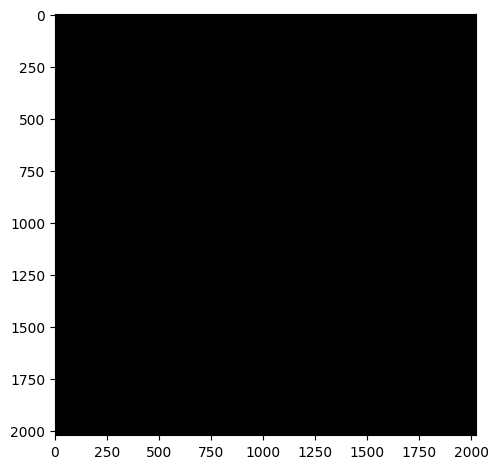

In [10]:
io.imshow(result_image[0].numpy())